# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline
import random
import check_test
from plot_utils import plot_values

In [2]:
from collections import deque
import pandas as pd
import seaborn as sns

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [3]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [4]:
print(env.action_space)
print(env.observation_space)
env.nS

Discrete(4)
Discrete(48)


48

In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

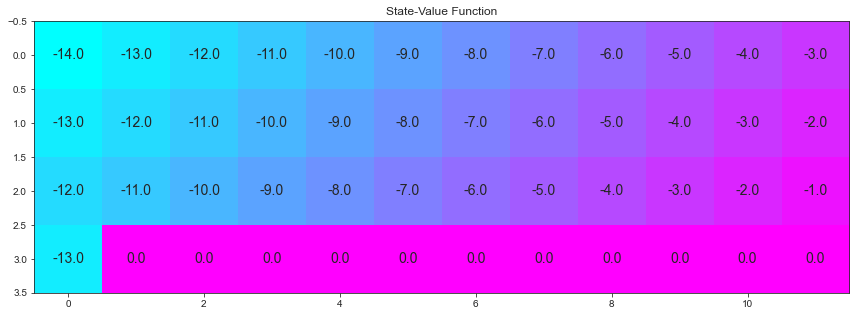

In [5]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `V`: This is a dictionary where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [6]:
def update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    """Returns updated Q-value for the most recent experience."""
    current = Q[state][action]  # estimate in Q-table (for current state, action pair)
    # get value of state, action pair at next time step
    Qsa_next = Q[next_state][next_action] if next_state is not None else 0    
    target = reward + (gamma * Qsa_next)               # construct TD target
    new_value = current + (alpha * (target - current)) # get updated value
    return new_value

def get_epsilon_greedy_action(Q, state, nA, eps):
#     nA = len(Q[state])
#     if random.random() > eps:
#         action = np.argmax(Q[state])
#     else:
#         action = random.choice(np.arange(nA))
#     return action        
    """Selects epsilon-greedy action for supplied state.
    
    Params
    ======
        Q (dictionary): action-value function
        state (int): current state
        nA (int): number actions in the environment
        eps (float): epsilon
    """
    if random.random() > eps: # select greedy action with probability epsilon
        return np.argmax(Q[state])
    else:                     # otherwise, select an action randomly
        return random.choice(np.arange(env.action_space.n))

In [7]:
def plot_score(scores, window, num_episodes):
    fig, ax = plt.subplots(figsize=(20, 10))
    sns.lineplot(x=np.linspace(0,num_episodes,len(scores),endpoint=False), y=np.asarray(scores))
    ax.set_xlabel('Episode Number')
    ax.set_ylabel(f'Avergae Reward (window size:{window})')


Episode 100/100 Best Average Reward over 100 Episodes: -405.46


defaultdict(<function __main__.sarsa.<locals>.<lambda>()>,
            {36: array([  -17.,  -648., -1456.,  -753.]),
             24: array([ -16., -452., -518., -439.]),
             12: array([  -24.,   -15., -2386.,  -530.]),
             0: array([-1459.,  -134.,  -745.,  -349.]),
             13: array([ -32.,  -14., -250.,  -30.]),
             1: array([-1359.,  -539.,   -31.,  -235.]),
             25: array([-841.,   -8., -463., -451.]),
             26: array([ -45., -534., -958.,  -28.]),
             14: array([ -13., -954., -846., -960.]),
             27: array([  -15., -1138.,  -545.,  -327.]),
             15: array([ -12., -319.,  -15., -338.]),
             28: array([ -15.,  -14., -644.,  -24.]),
             29: array([  -13.,  -118., -1358.,   -14.]),
             3: array([  -24.,   -11., -1059.,   -31.]),
             2: array([-927.,  -12.,  -44.,  -20.]),
             4: array([-16., -28., -10., -16.]),
             5: array([-12., -11., -13., -15.]),
         

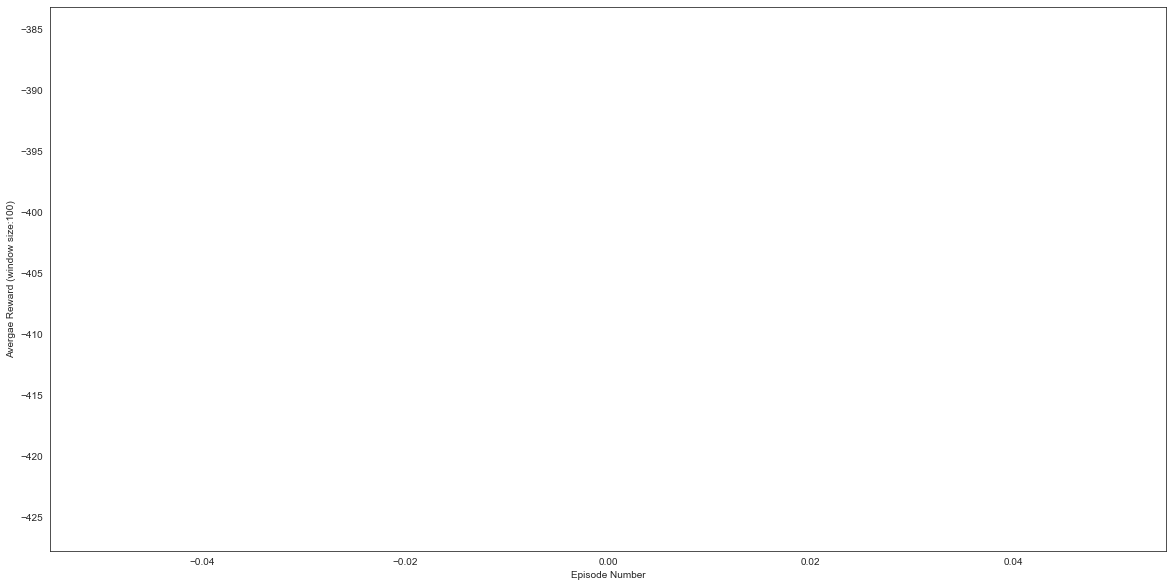

In [15]:
def sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    
    
    # initialize performance monitor parameters
    plot_every = 100
    ep_scores = deque(maxlen=plot_every)
    avg_scores = deque(maxlen=num_episodes)
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush() 
            
        # monitor performance
        score = 0.
        step = 0
        
        ### observe S0
        state = env.reset()
        ## TODO: complete the function
        
        ### set epsilon
        eps = 1.0 / i_episode
        
        ### choose action A0
        action = get_epsilon_greedy_action(Q, state, nA, eps)
        
        ### repeat
        while True:
            next_state, reward, done, info = env.step(action)
            
            #### update performance metrics
            score += reward
            step += 1
            
            #### update Q
            if not done:
                next_action = get_epsilon_greedy_action(Q, next_state, nA, eps)

                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward, next_state, next_action)
                #### t = t + 1
                state = next_state
                action = next_action
                
            if done:
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward)
                ep_scores.append(score)
                break           
            
        
        # track performance metrics
        
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(ep_scores))

 
    # show performance metrics
    # plot_metrics(ep_scores, ep_steps)
    plot_score(avg_scores, plot_every, num_episodes)
    
    # print best 100-episode performance
    print(f' Best Average Reward over {plot_every} Episodes: {np.max(avg_scores)}')    
                                 
    return Q

Q_sarsa = sarsa(env, 100, 1)
Q_sarsa

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 10000/10000 Best Average Reward over 100 Episodes: -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  1  1  1  2  1  1  0]
 [ 1  1  3  1  2  1  3  1  1  2  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


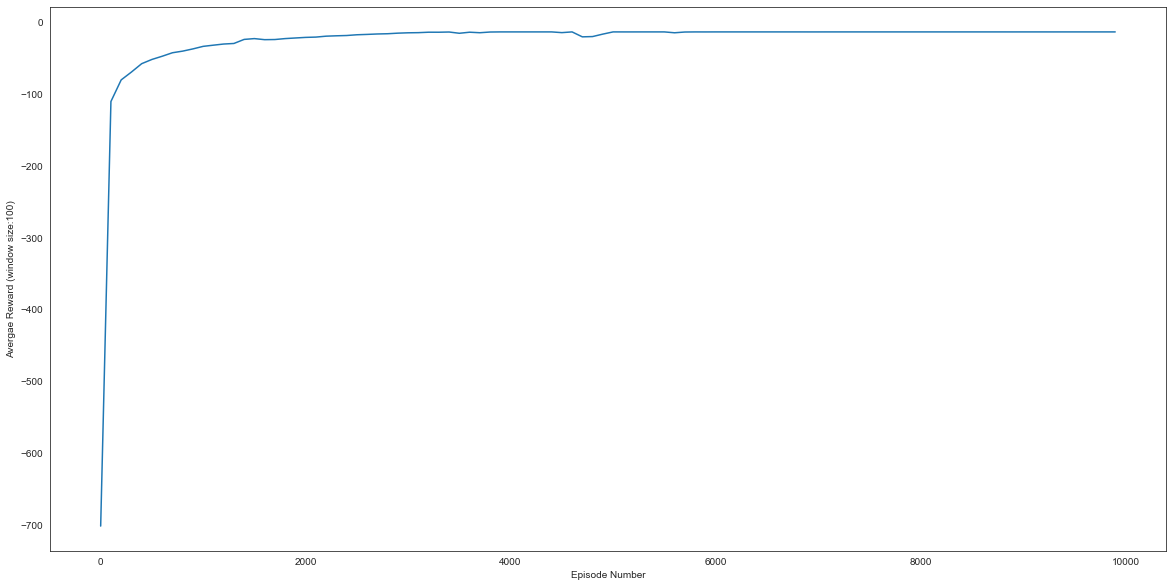

In [16]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 10000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

In [ ]:
# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
check_test.run_check('td_prediction_check', np.array(V_sarsa).reshape(4, -1))
plot_values(V_sarsa)

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [ ]:
def q_learning(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    # Performance monitor
    episode_scores = deque(maxlen=100)
    avg_scores = deque(maxlen=num_episodes)    
    
    # starting exploration rate
    eps_init = 1
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 10 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        
        ### Keep track of score over the full epsiode
        score = 0
        
        # determine epsilon for current episode
#         eps_i = 1 / i_episode
        del_i = max((num_episodes - i_episode)/num_episodes, 0)
        eps_i = (eps_init - 0.005)*del_i + 0.005
        
        # set values for looping over steps
        state = env.reset()
        done = False
        
        while not done:
            # Derive e-greedy policy
            policy = get_epsilon_greedy_policy(env, Q, eps_i)
            action = select_action(policy, state)
            next_state, reward, done, info = env.step(action)
            
            # Update Q
            greedy_policy = get_epsilon_greedy_policy(env, Q, 0)
            max_next_action = select_action(policy, next_state)
            Q[state][action] += alpha * (reward + (gamma * Q[next_state][max_next_action]) - Q[state][action])
            
            # Update curr state, score
            state = next_state
            score += reward
            
         # Keep record of score over many episodes
        episode_scores.append(score)
        avg_scores.append(np.mean(episode_scores))

    # Plot scores
    fig, ax = plt.subplots(figsize=(5, 10))
    sns.set_style('darkgrid')
    sns.lineplot(x=list(range(len(avg_scores))), y=avg_scores, ax=ax)
            
        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

In [ ]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 20000, .1)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [ ]:
def get_expected_Q(Q, policy, state):
    return np.sum(Q[state] * policy[state])

In [ ]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    # Performance monitor
    episode_scores = deque(maxlen=100)
    avg_scores = deque(maxlen=num_episodes)
    
    # starting exploration rate
    eps_init = 1
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        
        ### Keep track of score over the full epsiode
        score = 0
        
        # determine epsilon for current episode
        del_i = max((num_episodes - i_episode)/num_episodes, 0)
        eps_i = (eps_init - 0.1)*del_i + 0.1
        
        # set values for looping over steps
        state = env.reset()
        done = False
        
        while not done:
            # Derive e-greedy policy
            policy = get_epsilon_greedy_policy(env, Q, eps_i)
            action = select_action(policy, state)
            next_state, reward, done, info = env.step(action)
            
            # Update Q
            ## Compute expected Q from next state
            expected_Q = get_expected_Q(Q, policy, state)
            
            ## Compute new Q for curr state, action pair
            Q[state][action] += alpha * (reward + (gamma * expected_Q) - Q[state][action])
            
            # Update curr state, score
            state = next_state
            score += reward
            
        # Keep record of score over many episodes
        episode_scores.append(score)
        avg_scores.append(np.mean(episode_scores))

    # Plot scores
    fig, ax = plt.subplots(figsize=(5, 10))
    sns.set_style('darkgrid')
    sns.lineplot(x=list(range(len(avg_scores))), y=avg_scores, ax=ax)

        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

In [ ]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 10000, 0.2)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])

### Part 4: TD Control: TD(0)

In this section, you will write your own implementation of the TD(0) algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `V`: This is a one-dimensional arrays`V[s]` is the estimated state value corresponding to state `s` .


In [ ]:
TERMINAL_STATE = 47

In [ ]:
def td0(env, policy, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    V = np.zeros(env.nS)
    # initialize performance monitor
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 2 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        ## TODO: complete the function
        state = env.reset()
        done = False
        
        while state != TERMINAL_STATE:
            action = policy[state]
            next_state, reward, done, info = env.step(action)
            V[state] = V[state] + alpha * (reward + gamma*V[next_state] - V[state])
            state = next_state
            if done:
                break
            
    return V


We will find a policy from next step and check this code.

In [ ]:
V_sarsa = td0(env, policy_sarsa, 1000, .01)
plot_values(V_sarsa)